# Assignment 2: Multi-layer Feed Forward Neural Networks
Solutions to assignment #2 by K. Sai Somanath, 18MCMT28

## Feature selection
In this notebook, I demonstrate the different error rates obtained when I use PCA to reduce the dimensions and comapre the results(accuracies / error rates) with the intial model(1)

In [1]:
# Importing necessary libraries
import numpy as np
from matplotlib import pyplot as plt 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import os
import struct

## Extracting data

In [2]:
# Some utility functions to read and extract data in desired format
def read(dataset = "training", path = "."):
    if dataset is "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
    else:
        print("dataset must be 'testing' or 'training'")

    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)

    with open(fname_img, 'rb') as fimg:
        _, __, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows * cols)

    get_img = lambda index: (lbl[index], img[index])

    # Create an iterator which returns each image in turn
    for i in range(len(lbl)):
        yield get_img(i)

def show(image):
    from matplotlib import pyplot
    import matplotlib as mpl
    fig = pyplot.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image.reshape(28, 28), cmap=mpl.cm.gray)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    pyplot.show()

In [3]:
# Reading the images
TRAIN = read('training', 'MNIST'); TEST = read('testing', 'MNIST')

In [4]:
img_train = []; lbl_train = []
img_test = []; lbl_test = []

for temp in TRAIN:
    img_train.append(temp[1])
    lbl_train.append(temp[0])

for temp in TEST:
    img_test.append(temp[1])
    lbl_test.append(temp[0])

img_train = np.array(img_train); lbl_train = np.array(lbl_train)
img_test = np.array(img_test); lbl_test = np.array(lbl_test)
lbl_train = np.eye(10)[lbl_train]
lbl_test = np.eye(10)[lbl_test]
img_train = img_train / 255
img_test = img_test / 255

## The MLFFNN

In [5]:
class Relu:
    @staticmethod
    def activation(z):
        z[z < 0] = 0
        return z
    
    @staticmethod
    def derivative(z):
        z[z < 0] = 0
        z[z > 0] = 1
        return z
        
class Sigmoid:
    @staticmethod
    def activation(z):
        return 1 / (1 + np.exp(-z))
    
    @staticmethod
    def derivative(z):
        return Sigmoid.activation(z) * (1 - Sigmoid.activation(z))
    
class MSE:
    def __init__(self, activation_fn=None):
        self.activation_fn = activation_fn
            
    def activation(self, z):
        return self.activation_fn.activation(z)

    @staticmethod
    def loss(y_true, y_pred):
        return np.mean((y_pred - y_true)**2)

    @staticmethod
    def derivative(y_true, y_pred):
        return y_pred - y_true

    def delta(self, y_true, y_pred):
        return self.derivative(y_true, y_pred) * self.activation_fn.derivative(y_pred)
    

class NeuralNetwork(object):
    def __init__(self, dimensions, activation_fns):
        self.dimensions = dimensions
        self.n_layers = len(dimensions)
        self.loss = None
        self.learning_rate = None
        self.weights = {}
        self.bais = {}
        self.activations = {}
        for i in range(self.n_layers - 1):
            self.weights[i + 1] = np.random.randn(dimensions[i], dimensions[i + 1]) / np.sqrt(dimensions[i])
            self.bais[i + 1] = np.zeros(dimensions[i + 1])
            self.activations[i + 2] = activation_fns[i]
    
    def __deepcopy__(self, memo):
        deepcopy_method = self.__deepcopy__
        self.__deepcopy__ = None
        cp = deepcopy(self, memo)
        self.__deepcopy__ = deepcopy_method
        # custom treatments
        cp.weights = {}; cp.bais = {}
        for i in range(cp.n_layers - 1):
            cp.weights[i + 1] = np.random.randn(cp.dimensions[i], cp.dimensions[i + 1]) / np.sqrt(cp.dimensions[i])
            cp.bais[i + 1] = np.zeros(cp.dimensions[i + 1])

        return cp
    
    def feed_forward(self, x):
        z = {}
        activated = {1: x}
        for i in range(1, self.n_layers):
            z[i + 1] = np.dot(activated[i], self.weights[i]) + self.bais[i]
            activated[i + 1] = self.activations[i + 1].activation(z[i + 1])
        return z, activated
    
    def back_propagation(self, z, a, y_true):
        delta = self.loss.delta(y_true, a[self.n_layers])
        partial_derivative = np.dot(a[self.n_layers - 1].T, delta)

        update_params = {
            self.n_layers - 1: (partial_derivative, delta)
        }

        for i in reversed(range(2, self.n_layers)):
            delta = np.dot(delta, self.weights[i].T) * self.activations[i].derivative(z[i])
            partial_derivative = np.dot(a[i - 1].T, delta)
            update_params[i - 1] = (partial_derivative, delta)

        for key, values in update_params.items():
            self.update_fn(key, values[0], values[1])
        
    def update_fn(self, key, partial_derivative, delta):
        self.weights[key] -= self.learning_rate * partial_derivative
        self.bais[key] -= self.learning_rate * np.mean(delta, 0)

    def learn(self, x, y_true, loss, epochs, batch_size, learning_rate):
        self.loss = loss(self.activations[self.n_layers])
        self.learning_rate = learning_rate
        for i in range(epochs):
            seed = np.arange(x.shape[0])
            np.random.shuffle(seed)
            x_ = x[seed]
            y_ = y_true[seed]
            for j in range(x.shape[0] // batch_size):
                k = j * batch_size
                l = (j + 1) * batch_size
                z, a = self.feed_forward(x_[k:l])
                self.back_propagation(z, a, y_[k:l])
            _, _a = self.feed_forward(x)
            print("Epoch:", i + 1, "Loss:", self.loss.loss(y_true, _a[self.n_layers]), end='\r')
    
    def predict(self, x):
        _, a = self.feed_forward(x)
        return a[self.n_layers]

## Feature extraction and selection
I use PCA to extract features and then train neural network on those features. 

In [6]:
scaler = StandardScaler()
scaler.fit(img_train)
train_img = scaler.transform(img_train)
test_img = scaler.transform(img_test)

Now, I train the network on different number of features and store the error rates. All the networks use similar achitecture and use 100 epochs for training

In [7]:
errors = []; feature_set = []
n_components = np.arange(0.90, 1., .02)
print(n_components)

[0.9  0.92 0.94 0.96 0.98]


In [8]:
for index, noc in enumerate(n_components):
    pca = PCA(noc)
    print('Fitting PCA on train data for', noc, 'number of components such that the amount of variance is greater than the percentage specified')
    pca.fit(img_train)
    print()
    train_img = pca.transform(img_train)
    test_img = pca.transform(img_test)
    features = len(pca.components_)
    feature_set.append(features)
    print('Trainig network', index + 1, 'with', features, 'features')
    nn = NeuralNetwork((features, 100, 10), (Relu, Sigmoid))
    nn.learn(train_img, lbl_train, MSE, 100, 128, 0.01)
    print()
    # Make predictions on the test set
    y_pred = np.argmax(nn.predict(test_img), axis=1)
    # Get the true labels
    y_true = np.argmax(lbl_test, axis=1)
    acc = accuracy_score(y_true, y_pred) * 100
    print("Accuracy: ", acc, "%", "; Number of features:", features)
    errors.append(acc)

Fitting PCA on train data for 0.9 number of components such that the amount of variance is greater than the percentage specified

Trainig network 1 with 87 features
Epoch: 100 Loss: 0.00013969618351190156
Accuracy:  98.03 % ; Number of features: 87
Fitting PCA on train data for 0.92 number of components such that the amount of variance is greater than the percentage specified

Trainig network 2 with 106 features
Epoch: 100 Loss: 8.188886009031375e-05
Accuracy:  97.89999999999999 % ; Number of features: 106
Fitting PCA on train data for 0.9400000000000001 number of components such that the amount of variance is greater than the percentage specified

Trainig network 3 with 134 features
Epoch: 100 Loss: 4.3217980701034415e-05
Accuracy:  98.00999999999999 % ; Number of features: 134
Fitting PCA on train data for 0.9600000000000001 number of components such that the amount of variance is greater than the percentage specified

Trainig network 4 with 180 features
Epoch: 100 Loss: 2.3337047174

## Plotting the error rates

Text(0.5,1,'#Feature v/s Error rates')

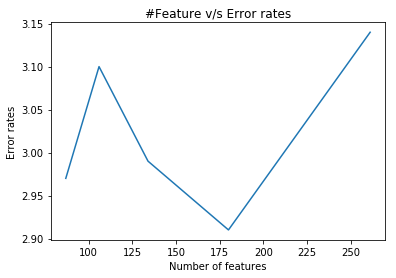

In [21]:
errors = [100 - x for x in errors]
plt.plot(feature_set, errors)
plt.ylabel('Error rates')
plt.xlabel('Number of features')
plt.title('#Feature v/s Error rates')

The graph clearly shows that as the number of features increases, the error rates decreases until a threshold. After that the error seems to incerase. This might be due to the fact that we only train the model for about 100 epochs and more epochs are required. 

Also, we can see that we used less features and less number of epochs to train the same network at about the same accuracy as model (1)